# Predicting purchasers in June

In [1]:
#make  jupyter notebook be able to show multiple outputs from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
pd.options.display.max_columns = None


#### Get in data

In [2]:
orders = pd.read_csv(r"C:\Users\jibso\Desktop\photobox\order_details.txt", sep='	')
visits = pd.read_csv(r"C:\Users\jibso\Desktop\photobox\visits.txt", sep='	')

#### Orders explore and reformat

In [3]:
orders.head()
orders.shape
orders.dtypes

#fix data types
orders[["item_category_id", "item_subcategory_id"]] = orders[["item_category_id", "item_subcategory_id"]].astype(str) 
#orders['order_date'] = pd.to_datetime(orders['order_date'], utc=True)

orders.describe()
orders[orders.columns.difference(['rev_gbp'])].describe()


,member_id,order_id,order_date,item_category_id,item_subcategory_id,rev_gbp
0,859a1b2a5fba4552f3a85642c5bf9a7e,357d65f145e2b2883397b22ffd146ccb,2017-06-16,3,31,1.83
1,f3d20a744e8b977cc8ed98498c5ad155,c017417d3e209de3e444517767c2bcee,2017-01-23,1,13,1.51
2,2d9c971585b8ac6766c3df151400f0d4,7dbf66239dd3b1af8314fab826e211c0,2016-12-06,1,13,6.97
3,7422af475194df996c1c7f9f9988beb1,38c3cb8d770c9f8f04b77f4312dac1a1,2017-04-17,3,31,7.57
4,e3a4131d67aee3f351bda573a9fc6529,2f693ef1a7f5183099951a025840c3dc,2016-07-10,1,13,1.73


(98716, 6)

member_id               object
order_id                object
order_date              object
item_category_id         int64
item_subcategory_id      int64
rev_gbp                float64
dtype: object

,rev_gbp
count,98716.000000
mean,3.252118
std,6.248531
min,0.000000
25%,0.900000
50%,1.830000
75%,4.190000
max,560.880000


,item_category_id,item_subcategory_id,member_id,order_date,order_id
count,98716,98716,98716,98716,98716
unique,3,5,38743,365,68863
top,1,31,79b851ac3660b977727d0e531b79d254,2017-06-12,0133bd33ca430c10c1336533d494eb0c
freq,51317,44258,247,1793,73


In [4]:
orders["item_category_id"].value_counts(dropna=False)
orders["item_subcategory_id"].value_counts(dropna=False)

1    51317
3    44258
5     3141
Name: item_category_id, dtype: int64

31    44258
13    23337
11    20419
16     7561
51     3141
Name: item_subcategory_id, dtype: int64

#### Visits explore and reformat

In [5]:
visits.head()
visits.shape
#visits.dtypes

visits[["os", "devicecat","language","channel"]] = visits[["os", "devicecat","language","channel"]].astype(str) 
visits.dtypes

visits.describe()

,member_id,visit_date,os,devicecat,language,channel
0,d36ef0fd8f31f19c1699e956c7fe239a,2017-06-07,1,1,5,1
1,d5e29109f3f3d9adca0be171e8e9bde7,2017-06-29,1,1,8,3
2,9817c77dc2461492e7ce81eb1bec70da,2017-06-08,4,1,5,1
3,4ce69c8e5d2706d2fa83c1318e2d8c76,2017-06-24,1,1,5,1
4,5c3790d928339a08595c6f634c891ccc,2017-04-06,1,1,5,1


(439449, 6)

member_id     object
visit_date    object
os            object
devicecat     object
language      object
channel       object
dtype: object

,member_id,visit_date,os,devicecat,language,channel
count,439449,439449,439449,439449,439449,439449
unique,47348,364,6,3,9,9
top,ef3bebb243efb6f00344ba494ab3f53e,2017-06-12,1,1,3,1
freq,585,4667,249589,313406,190493,199853


In [6]:
#check levels and spread
visits["os"].value_counts(dropna=False)
visits["devicecat"].value_counts(dropna=False)
visits["language"].value_counts(dropna=False)
visits["channel"].value_counts(dropna=False)

1    249589
2     88212
4     64685
3     33970
8      2982
9        11
Name: os, dtype: int64

1    313406
3     94020
2     32023
Name: devicecat, dtype: int64

3    190493
5    189038
1     13510
6     13209
7     11861
4      9473
2      5193
8      4213
9      2459
Name: language, dtype: int64

1    199853
2    101595
9     65067
4     43086
3     19572
6      5196
7      2401
5      1497
8      1182
Name: channel, dtype: int64

In [7]:
#collpase levels- without actual context of what they are can't say if this ideal approach, but these levels won't
# be significant variables in a model as is due to small number
#Also replace the numbers with a text as later on will transpose to make columns and numbers aren't good headers

#os
def col_os(string):
    if string in ['3','8','9']:
        return 'os_Other'    
    else:
        return 'os_'+ string    
visits['os_cut'] = visits["os"].apply(col_os)

#language
def col_language(string):
    if string in ['3','5']:
        return 'lang_'+string    
    else:
        return 'lang_other'    
visits['language_cut'] = visits["language"].apply(col_language)

#channel
def col_chan(string):
    if string in ['1','2','9','4']:
        return 'channel'+string    
    else:
        return 'channel_Other'    
visits['channel_cut'] = visits["channel"].apply(col_chan)


visits["os_cut"].value_counts(dropna=False)
visits["language_cut"].value_counts(dropna=False)
visits["channel_cut"].value_counts(dropna=False)
visits.head()

os_1        249589
os_2         88212
os_4         64685
os_Other     36963
Name: os_cut, dtype: int64

lang_3        190493
lang_5        189038
lang_other     59918
Name: language_cut, dtype: int64

channel1         199853
channel2         101595
channel9          65067
channel4          43086
channel_Other     29848
Name: channel_cut, dtype: int64

,member_id,visit_date,os,devicecat,language,channel,os_cut,language_cut,channel_cut
0,d36ef0fd8f31f19c1699e956c7fe239a,2017-06-07,1,1,5,1,os_1,lang_5,channel1
1,d5e29109f3f3d9adca0be171e8e9bde7,2017-06-29,1,1,8,3,os_1,lang_other,channel_Other
2,9817c77dc2461492e7ce81eb1bec70da,2017-06-08,4,1,5,1,os_4,lang_5,channel1
3,4ce69c8e5d2706d2fa83c1318e2d8c76,2017-06-24,1,1,5,1,os_1,lang_5,channel1
4,5c3790d928339a08595c6f634c891ccc,2017-04-06,1,1,5,1,os_1,lang_5,channel1


In [8]:
#Replace values in order channel with text for when transpose to make into a column later
#can't see way in the pivot function to add a prefix to the new column names like in R and this is easy if rather ugly
orders['item_category_id']= 'cat_'+ orders['item_category_id']
orders['item_subcategory_id']= 'subcat_'+ orders['item_subcategory_id']

### Produce the member level dataset for model training
Make target variable  
Derive other variables form raw data such as most rcent visit


In [9]:
#Total member universe to left join all other variables onto
members=pd.concat([visits["member_id"], orders["member_id"]]).drop_duplicates().to_frame()

In [10]:
#Target variable, those who bought in June
targets=orders[(orders.order_date >='2017-06-01' )][["member_id"]].drop_duplicates()
targets['target']=1

In [11]:
#summarise visits table
visits_part1= (visits[(visits.visit_date <='2017-05-31' )].groupby("member_id").agg({
    'visit_date':[np.size,np.max]
    ,'os':[pd.Series.nunique] 
    ,'devicecat':[pd.Series.nunique] 
    ,'language':[pd.Series.nunique] 
    ,'channel':[pd.Series.nunique] 
}))

#sort out the multilevel labels
visits_part1.columns = ["_".join(x) for x in visits_part1.columns.ravel()]
visits_part1.rename(columns={ 'visit_date_size' : 'num_visits_prejune', 'visit_date_amax':'most_recent_visit' }, inplace=True)

In [12]:
#calculate recency based on end of May assuming most available data
visits_part1['most_recent_visit']=pd.to_datetime(visits_part1['most_recent_visit'])
visits_part1['days_since_visit']=  (pd.to_datetime('2017-05-31') - visits_part1["most_recent_visit"]).dt.days

In [13]:
#make binary flag columns of the reduced level categorical variables at the member ID level
#should probably have a done a function for this

temp= visits[(visits.visit_date <='2017-05-31' )][["member_id","os_cut"]].drop_duplicates()
temp['tempvalue'] = 1
temp_os=temp.pivot(index='member_id', columns='os_cut', values='tempvalue')
temp_os.columns = [temp_os.columns.ravel()]
temp_os.columns = ["".join(x) for x in temp_os.columns.ravel()]

temp= visits[(visits.visit_date <='2017-05-31' )][["member_id","language_cut"]].drop_duplicates()
temp['tempvalue'] = 1
temp_language=temp.pivot(index='member_id', columns='language_cut', values='tempvalue')
temp_language.columns = ["".join(x) for x in temp_language.columns.ravel()]

temp= visits[(visits.visit_date <='2017-05-31' )][["member_id","channel_cut"]].drop_duplicates()
temp['tempvalue'] = 1
temp_channels=temp.pivot(index='member_id', columns='channel_cut', values='tempvalue')
temp_channels.columns = ["".join(x) for x in temp_channels.columns.ravel()]


#temp_os.head()
#temp_language.head()
#temp_channels.head()
#
#visits_part1.shape
#temp_os.shape
#temp_language.shape
#temp_channels.shape

In [14]:
#Orders table summarisation
orders_part1= (orders[(orders.order_date <='2017-05-31' )].groupby("member_id").agg({
     'order_date':[np.max]
    ,'order_id':[pd.Series.nunique] 
    ,'item_category_id':[pd.Series.nunique] 
    ,'item_subcategory_id':[pd.Series.nunique] 
    ,'rev_gbp':[np.sum,np.max] 
}))


orders_part1.columns = ["_".join(x) for x in orders_part1.columns.ravel()]
orders_part1.rename(columns={ 'order_id_nunique' : 'num_orders_prejune', 'order_date_amax':'most_recent_order'
                            ,'rev_gbp_sum':'total_spend','rev_gbp_amax':'max_order_spend'}, inplace=True)
orders_part1["average_order_spend"] = orders_part1["total_spend"] / orders_part1["num_orders_prejune"]

orders_part1.head()

,most_recent_order,num_orders_prejune,item_category_id_nunique,item_subcategory_id_nunique,total_spend,max_order_spend,average_order_spend
member_id,,,,,,,
00001f5554977595a5d9f2597dc74759,2016-09-13,1,1,1,7.23,7.23,7.230
00044f8dc4a61805b03fb8f545c4468e,2016-11-28,1,1,1,4.94,3.24,4.940
0006ad5f0be4a5205343070c08fa21d7,2016-07-12,1,1,1,0.53,0.53,0.530
000ab7bf9098b2062f1e5c4fd18cb27e,2017-02-07,2,1,1,1.79,1.47,0.895
00139c27ebfc43522288694083bec1a8,2017-05-15,1,1,1,1.75,1.75,1.750


In [15]:
#calculate recency based on end of May assuming most available data
orders_part1['most_recent_order']=pd.to_datetime(orders_part1['most_recent_order'])
orders_part1['days_since_order']=  (pd.to_datetime('2017-05-31') - orders_part1["most_recent_order"]).dt.days

#orders_part1.head()

In [16]:
#binary flags for which categories purchased
temp= orders[(orders.order_date <='2017-05-31' )][["member_id","item_category_id"]].drop_duplicates()
temp['tempvalue'] = 1
temp_category=temp.pivot(index='member_id', columns='item_category_id', values='tempvalue')
temp_category.columns = [temp_category.columns.ravel()]
temp_category.columns = ["".join(x) for x in temp_category.columns.ravel()]

temp= orders[(orders.order_date <='2017-05-31' )][["member_id","item_subcategory_id"]].drop_duplicates()
temp['tempvalue'] = 1
temp_subcategory=temp.pivot(index='member_id', columns='item_subcategory_id', values='tempvalue')
temp_subcategory.columns = ["".join(x) for x in temp_subcategory.columns.ravel()]

#temp_category.head()
#temp_subcategory.head()
#orders_part1.shape
#temp_category.shape
#temp_subcategory.shape

Merge temp tables onto member data and replace nulls with zeroes

In [17]:
#check no crazy dedupes have appeared
print("members" + "   " + str(members.shape))
print("targets" + "   " +  str(targets.shape))
print("visits_part1" + "   " +  str(visits_part1.shape))
print("temp_os" + "   " +  str(temp_os.shape))
print("temp_language" + "   " +  str(temp_language.shape))
print("temp_channels" + "   " +  str(temp_channels.shape))
print("orders_part1" + "   " +  str(orders_part1.shape))
print("temp_category" + "   " +  str(temp_category.shape))
print("temp_subcategory" + "   " +  str(temp_subcategory.shape))

members   (48878, 1)
targets   (19005, 2)
visits_part1   (37452, 7)
temp_os   (37452, 4)
temp_language   (37452, 3)
temp_channels   (37452, 5)
orders_part1   (27640, 8)
temp_category   (27640, 3)
temp_subcategory   (27640, 5)


In [18]:
#members.shape
merged=pd.merge(members, targets, how='left', left_on='member_id', right_on='member_id')
merged=pd.merge(merged, visits_part1, how='left', left_on='member_id', right_on='member_id')
merged=pd.merge(merged, temp_os, how='left', left_on='member_id', right_on='member_id')
merged=pd.merge(merged, temp_language, how='left', left_on='member_id', right_on='member_id')
merged=pd.merge(merged, temp_channels, how='left', left_on='member_id', right_on='member_id')
merged=pd.merge(merged, orders_part1, how='left', left_on='member_id', right_on='member_id')
merged=pd.merge(merged, temp_category, how='left', left_on='member_id', right_on='member_id')
merged=pd.merge(merged, temp_subcategory, how='left', left_on='member_id', right_on='member_id')

#merged.shape
#merged.head()
#list(merged)

In [19]:
#calculate if visited since last purchase
merged['visit_since_ordered']= np.where(merged['most_recent_visit']>merged['most_recent_order']  , '1', '0')
merged.head()

#drop the 2 date columns as won't put in model
merged.drop(['most_recent_visit','most_recent_order'], axis=1,inplace=True)

,member_id,target,num_visits_prejune,most_recent_visit,os_nunique,devicecat_nunique,language_nunique,channel_nunique,days_since_visit,os_1,os_2,os_4,os_Other,lang_3,lang_5,lang_other,channel1,channel2,channel4,channel9,channel_Other,most_recent_order,num_orders_prejune,item_category_id_nunique,item_subcategory_id_nunique,total_spend,max_order_spend,average_order_spend,days_since_order,cat_1,cat_3,cat_5,subcat_11,subcat_13,subcat_16,subcat_31,subcat_51,visit_since_ordered
0,d36ef0fd8f31f19c1699e956c7fe239a,1.0,11.0,2017-05-22,1.0,1.0,1.0,3.0,9.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,d5e29109f3f3d9adca0be171e8e9bde7,1.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,9817c77dc2461492e7ce81eb1bec70da,1.0,28.0,2017-05-31,1.0,1.0,1.0,4.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,2016-11-12,3.0,1.0,1.0,1.22,0.64,0.406667,200.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1
3,4ce69c8e5d2706d2fa83c1318e2d8c76,1.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5c3790d928339a08595c6f634c891ccc,1.0,84.0,2017-04-12,1.0,1.0,1.0,6.0,49.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,2017-04-09,4.0,2.0,3.0,19.54,10.07,4.885000,52.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1


In [20]:
#replace nulls with zeroes except certain columns 
#subset columns to do on
doing = merged.loc[:, merged.columns.difference(['days_since_visit','days_since_order','average_order_spend','max_order_spend'])].fillna(0)

#take columns not done on
notdoing= merged[['member_id','days_since_visit','days_since_order','average_order_spend','max_order_spend']]
#merge on member_id which is unaffected as has zero nulls

#doing.head()
#notdoing.head()

#doing.shape
#notdoing.shape

merged_again =pd.merge(notdoing, doing, how='inner', left_on='member_id', right_on='member_id')
#merged_again.shape
#merged_again.head()

In [21]:
#remove those who have no previous visits or orders as not a magician to predict them appearing in June
valid=merged_again[(merged_again.num_orders_prejune > 0) | (merged_again.num_visits_prejune>0)]
valid.shape

(38537, 36)

In [22]:
valid.set_index('member_id',inplace=True)

#### Investigation - predictor insight charts  
These will be used to filter variables going into model, no visible over-index then not going in

In [23]:
#Predictor insight charts
#show number of people in each group, and what % are in tgarget
temp=valid.copy()

#to make charts need a categorical variable or few distinct values so fit on x-axis
#using temp table make new grouped columns as needed and kill the old column 
variables_model = ['days_since_visit', 'cat_1', 'cat_3', 'cat_5', 'channel1', 'channel2', 'channel4', 'channel9',
                   'channel_Other', 'channel_nunique', 'devicecat_nunique', 'item_category_id_nunique', 
                   'item_subcategory_id_nunique', 'lang_3', 'lang_5', 'lang_other', 'language_nunique',
                   'num_orders_prejune', 'num_visits_prejune', 'os_1', 'os_2', 'os_4', 'os_Other','os_nunique',
                   'subcat_11', 'subcat_13', 'subcat_16', 'subcat_31', 'subcat_51', 'total_spend', 'visit_since_ordered',
                    'days_since_order','average_order_spend','max_order_spend']
for variable in variables_model:
    #print(variable + ': '+str(len(temp.groupby(variable))))
    if len(temp.groupby(variable))>12:        
        new_variable = "disc" + variable
        temp[new_variable] = pd.qcut(temp[variable], 5,duplicates='drop')
        temp.drop([variable],axis=1,inplace=True)

#temp.head()

In [24]:
#function to make table
def create_pig_table(df, target, variable):
    # Group by the variable you want to plot
    groups = df[[target,variable]].groupby(variable)
    pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()
    return pig_table

In [25]:
#put the table for each variable into a dictionary

#variables=list(temp)
variables= ['cat_1', 'cat_3', 'cat_5', 'channel1', 'channel2', 'channel4', 'channel9', 'channel_Other', 'channel_nunique',
 'devicecat_nunique', 'item_category_id_nunique', 'item_subcategory_id_nunique', 'lang_3', 'lang_5', 'lang_other',
 'language_nunique', 'os_1', 'os_2', 'os_4', 'os_Other', 'os_nunique', 'subcat_11', 'subcat_13', 'subcat_16', 'subcat_31',
 'subcat_51', 'visit_since_ordered', 'discdays_since_visit', 'discnum_orders_prejune', 'discnum_visits_prejune',
 'disctotal_spend', 'discdays_since_order', 'discaverage_order_spend', 'discmax_order_spend']

pig_tables = {}
# Loop over all variables
for variable in variables:
    # Create the predictor insight graph table
    pig_table = create_pig_table(temp, "target", variable)
    # Store the table in the dictionary
    pig_tables[variable] = pig_table
    
   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


In [26]:
#function to print the table and plot chart
def plot_pig(pig_table, variable):
    print(pig_table[variable])
    
    working=pig_table[variable]
    
    # Plot formatting
    plt.ylabel("Size", rotation=0, rotation_mode="anchor", ha="right")
    # Plot the bars with sizes
    working["Size"].plot(kind="bar", width=0.5, color="lightgray", edgecolor="none")
    # Plot the incidence line on secondary axis
    working["Incidence"].plot(secondary_y=True)
    # Plot formatting
    plt.xticks(np.arange(len(working)), working[variable].unique())
    plt.xlim([-0.5, len(working) - 0.5])
    plt.ylabel("Incidence", rotation=0, rotation_mode="anchor", ha="left")
    plt.xlabel(variable)
    # Show the graph
    plt.show()
    
#xticks(np.arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue'))


In [27]:
#plot_pig(pig_tables, "devicecat_nunique")
#plot_pig(pig_tables, "discaverage_order_spend")

cat_1
   cat_1  Incidence     Size
0    0.0   0.287528  21104.0
1    1.0   0.289623  17433.0


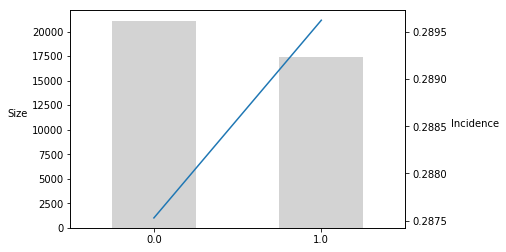

cat_3
   cat_3  Incidence     Size
0    0.0   0.263272  24545.0
1    1.0   0.332690  13992.0


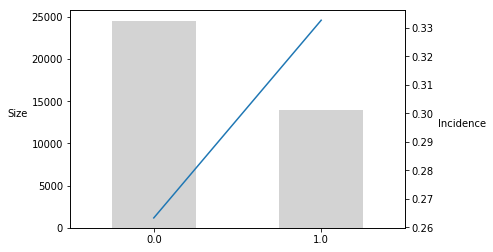

cat_5
   cat_5  Incidence     Size
0    0.0   0.286391  37152.0
1    1.0   0.344404   1385.0


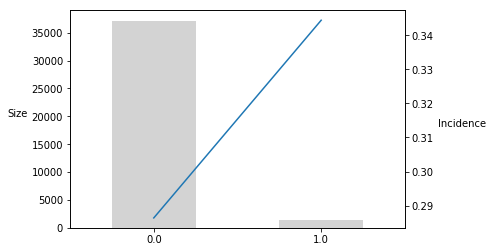

channel1
   channel1  Incidence     Size
0       0.0   0.319391   4662.0
1       1.0   0.284221  33875.0


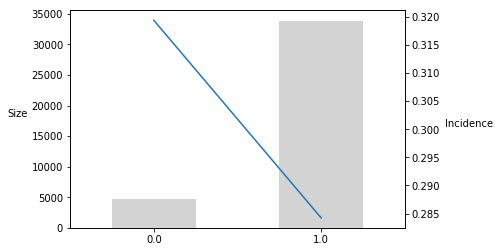

channel2
   channel2  Incidence     Size
0       0.0   0.229039  19250.0
1       1.0   0.347799  19287.0


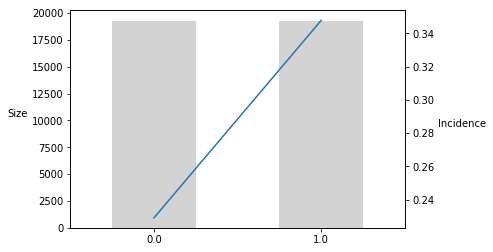

channel4
   channel4  Incidence     Size
0       0.0   0.260967  27992.0
1       1.0   0.361498  10545.0


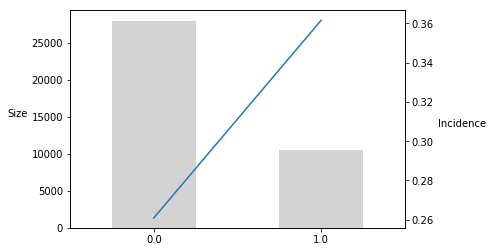

channel9
   channel9  Incidence     Size
0       0.0   0.257557  22496.0
1       1.0   0.331837  16041.0


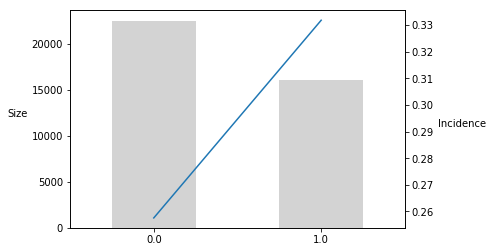

channel_Other
   channel_Other  Incidence     Size
0            0.0   0.264337  26905.0
1            1.0   0.344309  11632.0


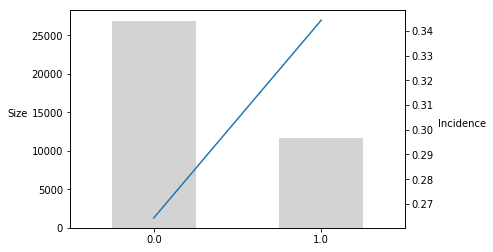

channel_nunique
   channel_nunique  Incidence     Size
0              0.0   0.176037   1085.0
1              1.0   0.226650   9486.0
2              2.0   0.253839  11137.0
3              3.0   0.313367   9082.0
4              4.0   0.375758   5280.0
5              5.0   0.443359   2048.0
6              6.0   0.493261    371.0
7              7.0   0.577778     45.0
8              8.0   0.666667      3.0


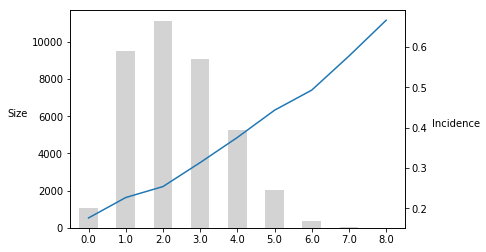

devicecat_nunique
   devicecat_nunique  Incidence     Size
0                0.0   0.176037   1085.0
1                1.0   0.267523  25452.0
2                2.0   0.331159  10270.0
3                3.0   0.413873   1730.0


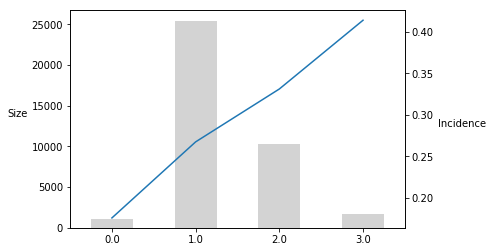

item_category_id_nunique
   item_category_id_nunique  Incidence     Size
0                       0.0   0.295035  10897.0
1                       1.0   0.253695  22732.0
2                       2.0   0.428541   4646.0
3                       3.0   0.549618    262.0


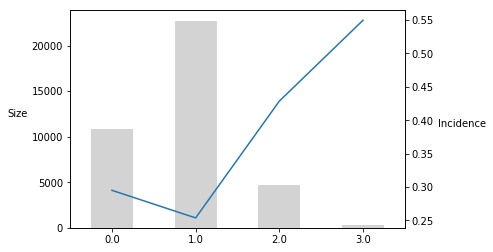

item_subcategory_id_nunique
   item_subcategory_id_nunique  Incidence     Size
0                          0.0   0.295035  10897.0
1                          1.0   0.247748  21651.0
2                          2.0   0.394605   4782.0
3                          3.0   0.525310   1047.0
4                          4.0   0.624161    149.0
5                          5.0   0.727273     11.0


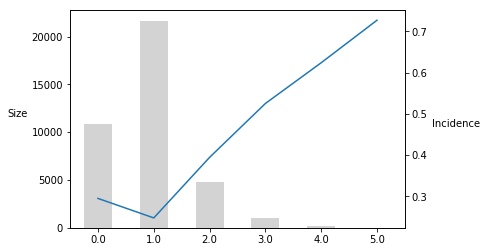

lang_3
   lang_3  Incidence     Size
0     0.0   0.280858  19152.0
1     1.0   0.296002  19385.0


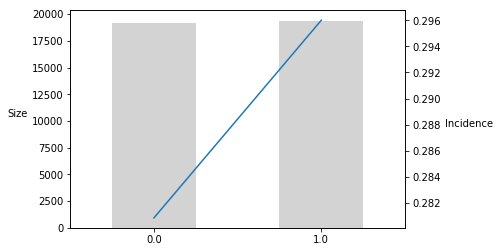

lang_5
   lang_5  Incidence     Size
0     0.0   0.263096  25523.0
1     1.0   0.338251  13014.0


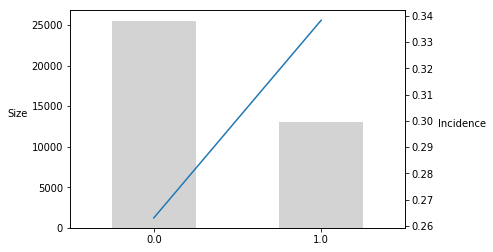

lang_other
   lang_other  Incidence     Size
0         0.0   0.307140  32057.0
1         1.0   0.196142   6480.0


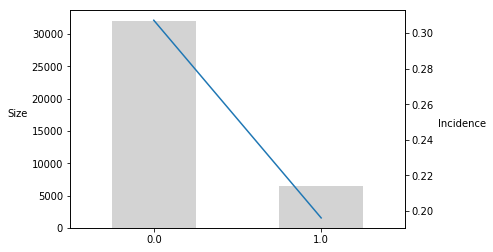

language_nunique
   language_nunique  Incidence     Size
0               0.0   0.176037   1085.0
1               1.0   0.290032  36027.0
2               2.0   0.331640   1378.0
3               3.0   0.413043     46.0
4               4.0   1.000000      1.0


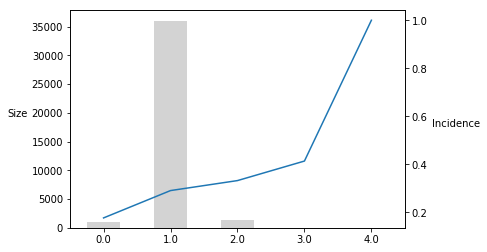

os_1
   os_1  Incidence     Size
0   0.0   0.267902  14244.0
1   1.0   0.300539  24293.0


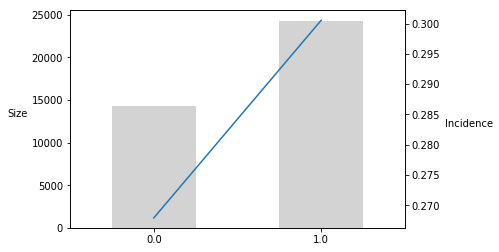

os_2
   os_2  Incidence     Size
0   0.0   0.275125  25403.0
1   1.0   0.314299  13134.0


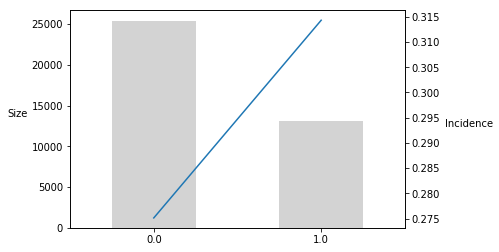

os_4
   os_4  Incidence     Size
0   0.0   0.280841  31484.0
1   1.0   0.322558   7053.0


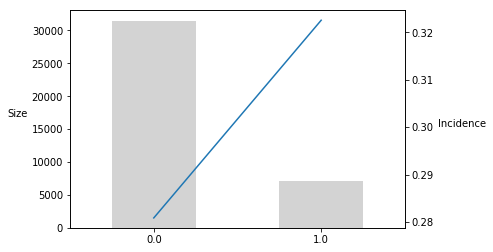

os_Other
   os_Other  Incidence     Size
0       0.0   0.284570  31827.0
1       1.0   0.307004   6710.0


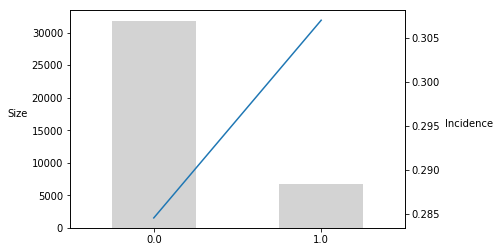

os_nunique
   os_nunique  Incidence     Size
0         0.0   0.176037   1085.0
1         1.0   0.266336  25235.0
2         2.0   0.335304  10656.0
3         3.0   0.403992   1453.0
4         4.0   0.415094    106.0
5         5.0   0.500000      2.0


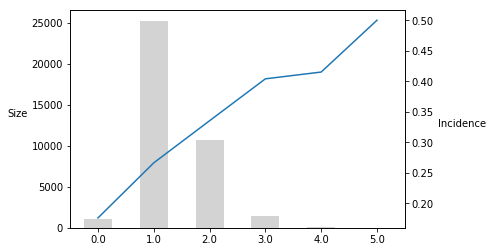

subcat_11
   subcat_11  Incidence     Size
0        0.0   0.271481  30131.0
1        1.0   0.349393   8406.0


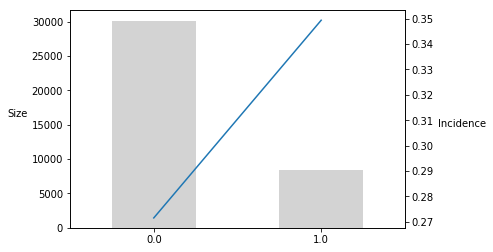

subcat_13
   subcat_13  Incidence     Size
0        0.0   0.295377  30087.0
1        1.0   0.263905   8450.0


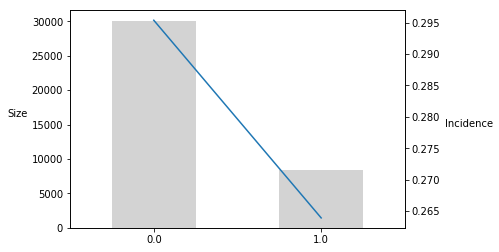

subcat_16
   subcat_16  Incidence     Size
0        0.0   0.285658  35763.0
1        1.0   0.324802   2774.0


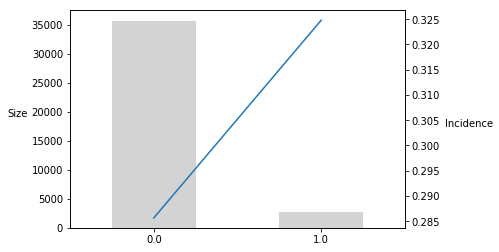

subcat_31
   subcat_31  Incidence     Size
0        0.0   0.263272  24545.0
1        1.0   0.332690  13992.0


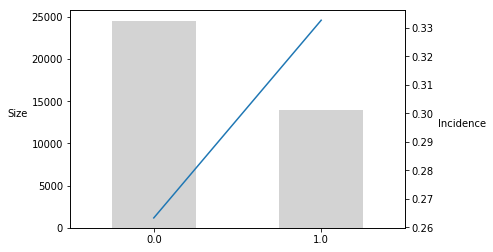

subcat_51
   subcat_51  Incidence     Size
0        0.0   0.286391  37152.0
1        1.0   0.344404   1385.0


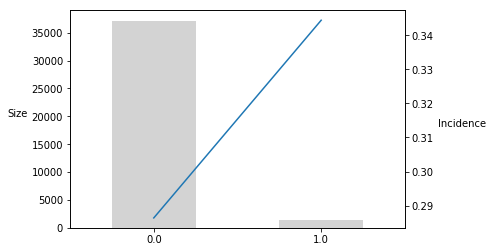

visit_since_ordered
  visit_since_ordered  Incidence     Size
0                   0   0.266508  23883.0
1                   1   0.324280  14654.0


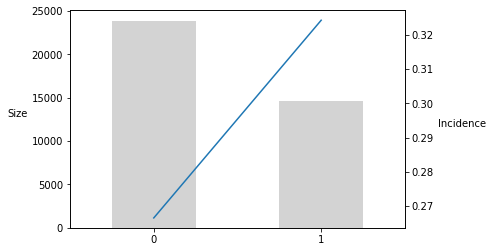

discdays_since_visit
  discdays_since_visit  Incidence    Size
0       (-0.001, 23.0]   0.548657  7635.0
1         (23.0, 85.0]   0.343275  7376.0
2        (85.0, 153.0]   0.224950  7495.0
3       (153.0, 188.0]   0.158743  7572.0
4       (188.0, 334.0]   0.178600  7374.0


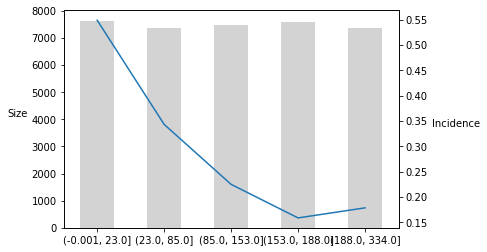

discnum_orders_prejune
  discnum_orders_prejune  Incidence     Size
0          (-0.001, 1.0]   0.241378  29083.0
1             (1.0, 2.0]   0.348577   5270.0
2           (2.0, 101.0]   0.540153   4184.0


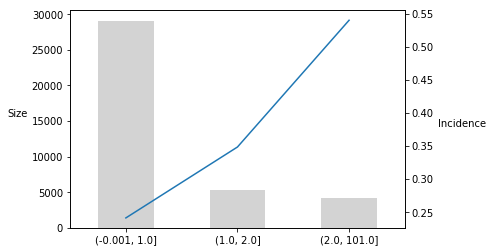

discnum_visits_prejune
  discnum_visits_prejune  Incidence     Size
0          (-0.001, 2.0]   0.206726  12103.0
1             (2.0, 3.0]   0.228319   3955.0
2             (3.0, 6.0]   0.253059   7765.0
3            (6.0, 13.0]   0.318945   7622.0
4          (13.0, 553.0]   0.467569   7092.0


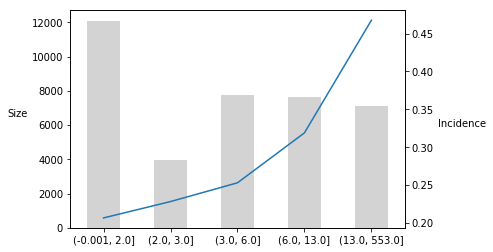

disctotal_spend
  disctotal_spend  Incidence     Size
0   (-0.001, 1.1]   0.271744  15441.0
1     (1.1, 3.41]   0.225475   7686.0
2    (3.41, 8.23]   0.279984   7704.0
3  (8.23, 1098.8]   0.393330   7706.0


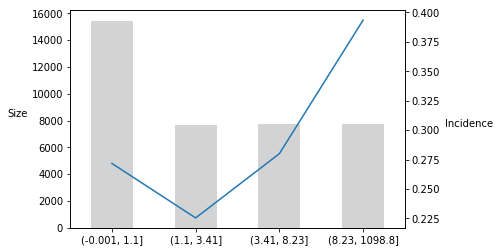

discdays_since_order
  discdays_since_order  Incidence    Size
0       (-0.001, 56.0]   0.449418  5585.0
1        (56.0, 123.0]   0.305480  5493.0
2       (123.0, 173.0]   0.252143  5600.0
3       (173.0, 233.0]   0.220293  5470.0
4       (233.0, 334.0]   0.199745  5492.0


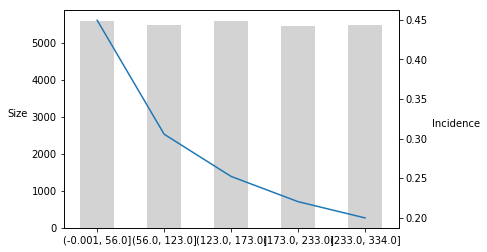

discaverage_order_spend
  discaverage_order_spend  Incidence    Size
0          (-0.001, 1.12]   0.248609  5571.0
1            (1.12, 2.23]   0.264079  5487.0
2            (2.23, 3.82]   0.305986  5546.0
3            (3.82, 6.51]   0.331521  5517.0
4          (6.51, 310.26]   0.279398  5519.0


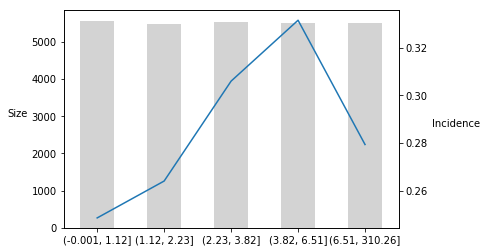

discmax_order_spend
  discmax_order_spend  Incidence    Size
0      (-0.001, 1.07]   0.237325  5562.0
1        (1.07, 2.23]   0.240145  5505.0
2        (2.23, 4.07]   0.282251  5527.0
3        (4.07, 6.96]   0.315942  5520.0
4      (6.96, 376.21]   0.353963  5526.0


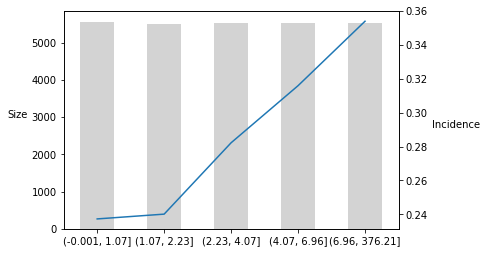

In [28]:
#plot and print table of every variable to make an unpleasantly large output
#size is number of rows
#incidence is % of that group that has a 1 for target, i.e. bought in June
for key, value in pig_tables.items():
    print(key)
    plot_pig(pig_tables, key)

Powerful variables for model (difference in incidence and enough size to bother):  
cat_3  
cat_5  
channel2  
channel4  
channel9  
channel_Other  
channel_nunique  
devicecat_nunique  
lang_5  
lang_other  
os_nunique  
subcat_11  
subcat_31  
visit_since_ordered  
num_orders_prejune  
num_visits_prejune  
total_spend  
days_since_visit  
 
days_since_order  
max_order_spend  

#### Data prep

In [29]:
#dataset without nulls
#Check how many nulls and % null by column
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
missing_values_table(valid)    
    
#drop these columns as have 28% nulls.
#if kept would have to delete rows, and then the dataset is only customers with previous order, whole different meaning
valid= valid.drop(['days_since_order','average_order_spend','max_order_spend'], axis=1)

#remove rows where days_since_visit is null
#some artefact of data production that order exists without a visit (earlier filtered to must have order or visit)
valid=valid[valid['days_since_visit'].notnull()]


Your selected dataframe has 35 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
days_since_order,10897,28.3
average_order_spend,10897,28.3
max_order_spend,10897,28.3
days_since_visit,1085,2.8


#### Investigation- Correlations

In [30]:
valid_upd_coltypes=valid.copy()

#redefine column types
valid_upd_coltypes[["target","os_1","os_2","os_4","os_Other","lang_3","lang_5","lang_other","channel1","channel2"
,"channel4","channel9","channel_Other","cat_1","cat_3","cat_5","subcat_11","subcat_13"
,"subcat_16","subcat_31","subcat_51"]] = valid_upd_coltypes[["target","os_1","os_2","os_4","os_Other","lang_3","lang_5","lang_other","channel1","channel2"
,"channel4","channel9","channel_Other","cat_1","cat_3","cat_5","subcat_11","subcat_13"
,"subcat_16","subcat_31","subcat_51"]].astype(str) 


#valid_upd_coltypes.dtypes

,days_since_visit,channel_nunique,devicecat_nunique,item_category_id_nunique,item_subcategory_id_nunique,language_nunique,num_orders_prejune,num_visits_prejune,os_nunique,total_spend
days_since_visit,1.000000,-0.284024,-0.197296,-0.139551,-0.167436,-0.063127,-0.217679,-0.330969,-0.198623,-0.126895
channel_nunique,-0.284024,1.000000,0.478059,0.245836,0.285605,0.144892,0.278463,0.557531,0.485831,0.154124
devicecat_nunique,-0.197296,0.478059,1.000000,0.177886,0.207304,0.108887,0.178765,0.345836,0.837005,0.106562
item_category_id_nunique,-0.139551,0.245836,0.177886,1.000000,0.944521,0.037892,0.528434,0.257239,0.181973,0.312877
item_subcategory_id_nunique,-0.167436,0.285605,0.207304,0.944521,1.000000,0.048803,0.566404,0.323020,0.213618,0.341964
language_nunique,-0.063127,0.144892,0.108887,0.037892,0.048803,1.000000,0.066507,0.187355,0.157086,0.075290
num_orders_prejune,-0.217679,0.278463,0.178765,0.528434,0.566404,0.066507,1.000000,0.519304,0.188588,0.555871
num_visits_prejune,-0.330969,0.557531,0.345836,0.257239,0.323020,0.187355,0.519304,1.000000,0.365788,0.293508
os_nunique,-0.198623,0.485831,0.837005,0.181973,0.213618,0.157086,0.188588,0.365788,1.000000,0.115082
total_spend,-0.126895,0.154124,0.106562,0.312877,0.341964,0.075290,0.555871,0.293508,0.115082,1.000000


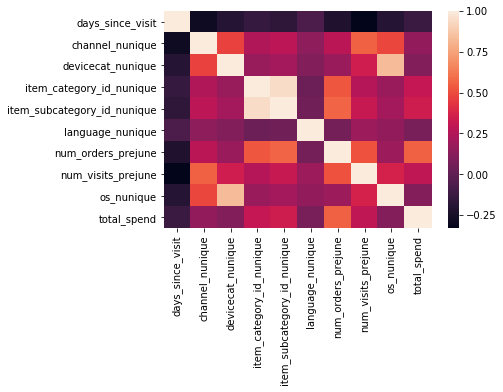

In [31]:
#have a look at correlations
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr = valid_upd_coltypes.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

valid_upd_coltypes.corr()

#### Make model
sklearn.linearmodel approach



# Try stepwise to choose variables

In [32]:
#function definitions 

from sklearn import linear_model
from sklearn.metrics import roc_auc_score

def auc(variables, target, basetable):
    X = basetable[variables]
    y = basetable[target]
    logreg = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

def next_best(current_variables,candidate_variables, target, basetable):
    best_auc = -1
    best_variable = None
    for v in candidate_variables:
        auc_v = auc(current_variables + [v], target, basetable)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
    return best_variable

def auc_train_test(variables, target, train, test):
    X_train = train[variables]
    X_test = test[variables]
    Y_train = train[target]
    Y_test = test[target]
    logreg = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
    # Fit the model on train data
    logreg.fit(X_train, Y_train)
    # Calculate the predictions both on train and test data
    predictions_train = logreg.predict_proba(X_train)[:,1]
    predictions_test = logreg.predict_proba(X_test)[:,1]
    # Calculate the AUC both on train and test data
    auc_train = roc_auc_score(Y_train, predictions_train)
    auc_test = roc_auc_score(Y_test,predictions_test)
    return(auc_train, auc_test)


In [33]:
#Run the stepwise to choose the top variables
#will check test-train for overfitting after

candidate_variables = list(valid.columns.values)
candidate_variables.remove("target")

current_variables = []

# The forward stepwise variable selection procedure
number_iterations = 20
for i in range(0, number_iterations):
    next_variable = next_best(current_variables, candidate_variables, "target", valid)
    current_variables = current_variables + [next_variable]
    candidate_variables.remove(next_variable)
    print("Variable added in step " + str(i+1)  + " is " + next_variable + ".")
print(current_variables)

#next_best(current_variables,candidate_variables, target, basetable)


Variable added in step 1 is days_since_visit.
Variable added in step 2 is lang_other.
Variable added in step 3 is num_visits_prejune.
Variable added in step 4 is channel1.
Variable added in step 5 is cat_1.
Variable added in step 6 is num_orders_prejune.
Variable added in step 7 is channel2.
Variable added in step 8 is channel4.
Variable added in step 9 is subcat_11.
Variable added in step 10 is os_4.
Variable added in step 11 is lang_5.
Variable added in step 12 is channel_Other.
Variable added in step 13 is total_spend.
Variable added in step 14 is visit_since_ordered.
Variable added in step 15 is subcat_16.
Variable added in step 16 is lang_3.
Variable added in step 17 is channel_nunique.
Variable added in step 18 is item_subcategory_id_nunique.
Variable added in step 19 is channel9.
Variable added in step 20 is os_nunique.
['days_since_visit', 'lang_other', 'num_visits_prejune', 'channel1', 'cat_1', 'num_orders_prejune', 'channel2', 'channel4', 'subcat_11', 'os_4', 'lang_5', 'chann

In [34]:
#make a test and learn group as want to test overfitting below

from sklearn.model_selection import train_test_split

feature_cols = list(valid.columns.values)
feature_cols.remove("target")

X = valid[feature_cols]
y = valid["target"]

#when the target incidence is low, it could be necessary to stratify, to make sure that the train and test
# data contain an equal percentage of targets
X_train, X_test, y_train, y_test =    train_test_split(X, y, test_size=0.4, stratify = y)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Check whether train and test have same percentage targets
print(round(sum(train['target'])/len(train), 2))
print(round(sum(test['target'])/len(test), 2))

0.29
0.29


In [35]:
#plot of AUC for test and train to show where the cutoff should be and see if overfitting

auc_values_train = []
auc_values_test = []
variables_evaluate = []

#variables selected from the stepwise
variables=['days_since_visit', 'lang_other', 'num_visits_prejune', 'channel1', 'cat_1', 'num_orders_prejune'
           , 'channel2', 'channel4', 'subcat_11', 'os_4', 'lang_5', 'channel_Other', 'total_spend',
           'visit_since_ordered', 'subcat_16', 'lang_3', 'channel_nunique', 'item_subcategory_id_nunique',
           'channel9', 'os_nunique']

# Iterate over the variables in variables
for v in variables:
    # Add the variable
    variables_evaluate.append(v)
    # Calculate the train and test AUC of this set of variables
    auc_train, auc_test = auc_train_test(variables_evaluate, "target", train, test)
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)

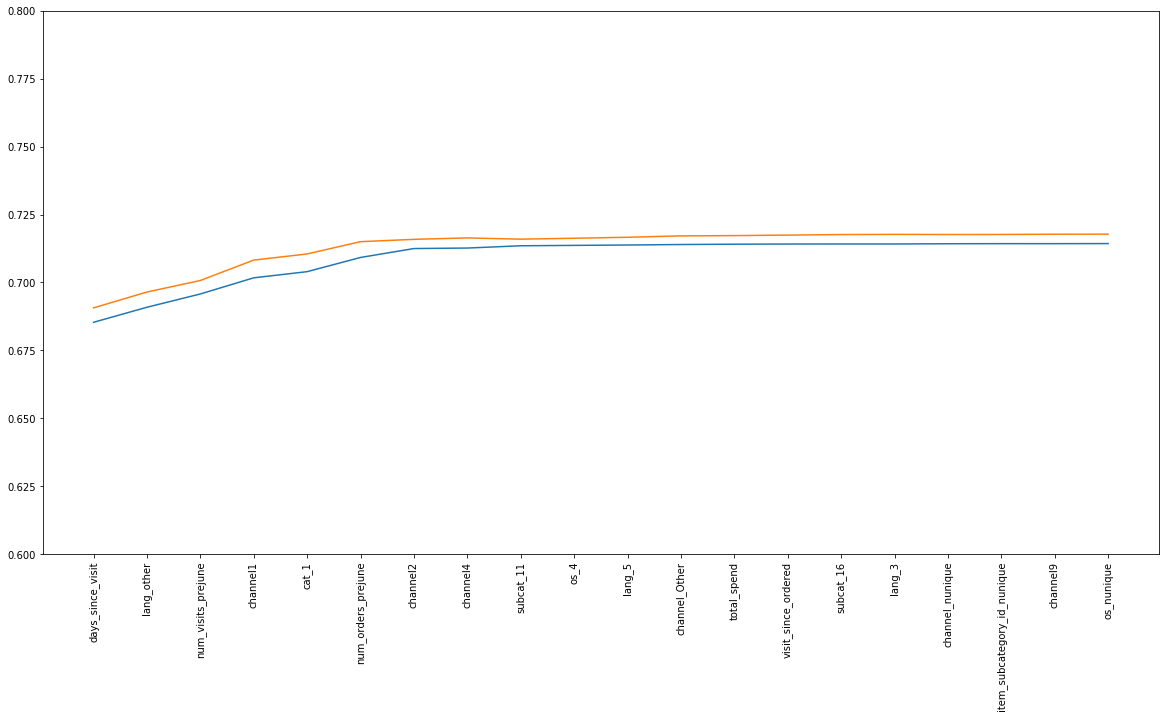

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [20, 10]

x = np.array(range(0,len(auc_values_train)))
y_train = np.array(auc_values_train)
y_test = np.array(auc_values_test)
plt.xticks(x, variables, rotation = 90)
plt.plot(x,y_train)
plt.plot(x,y_test)
plt.ylim((0.6, 0.8))
plt.show();

No more value being added once get to channel2, so list of variables for final model are:  
['days_since_visit', 'lang_other', 'num_visits_prejune', 'channel1', 'cat_1', 'num_orders_prejune'
           , 'channel2']

#### Model Build

In [37]:
#split dataset in features and target variable
feature_cols = ['days_since_visit', 'lang_other', 'num_visits_prejune', 'channel1',
                'cat_1', 'num_orders_prejune' , 'channel2']
X = valid[feature_cols] # Features
y = valid.target # Target variable

In [38]:
#split training test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [39]:
#fit a model
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs',max_iter=10000 )
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
coef = logreg.coef_
#print variables and coefficients
for p,c in zip(feature_cols,list(coef[0])):
    print(str(c) + '\t' + p )

-0.006383149811599997	days_since_visit
-0.6034986264713635	lang_other
0.01073017334940901	num_visits_prejune
-0.6856028024102077	channel1
-0.402073738850987	cat_1
0.1595976697946669	num_orders_prejune
0.30758668269487727	channel2


In [41]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
#Diagonal values accurate predictions

array([[6221,  386],
       [2190,  566]], dtype=int64)

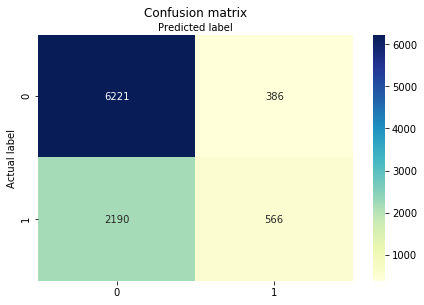

In [42]:
#plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

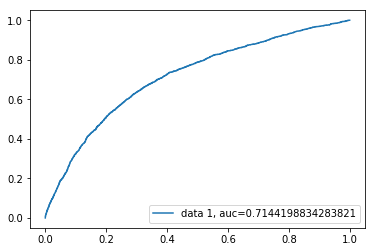

In [43]:
# gains curve and AUC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba,pos_label=1)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show();

In [44]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred,pos_label=1))
print("Precision:",metrics.precision_score(y_test, y_pred,pos_label=1))
#Accuracy overall how many labelled right
#Recall how many of the Actual Positives our model capture through labeling it as Positive (True Positive)
#Precision of those predicted positive, how many of them are actual positive.

Accuracy: 0.7248745060343907
Recall: 0.2053701015965167
Precision: 0.5945378151260504


## Model conclusion

Model performance is satisfactory, but considerable room for improvement with further variables and more importantly an increased understanding of the variables provided, which would inform the best way to interpret and handle the variables for the model

As expected the best positive predictors are engagement variables such as days since visit, number of prior visits and orders
The less used languages which I grouped into "Other" were a significant negative variable, perhaps the site is not set up to handle foreign visitors properly, the itnernational sites are lower quality or delivery costs are a deterrence for international customers.
The channel variables showed some power but withotu context aren't interpretable


# Describe how this model might be used by business users 

Normally best to know why you need a model before building it, but this model could be used for:  
-  Prioritising media spend, may want to spend more on customers who are likely to spend to ensure they don't go to a competitor, or reduce spend if they're engaged so as not to erode margin. Perhaps could combine with prediciton of liekly spend to optimise
-  Drive lapsed or last chance targeted comms for those we think were highly likely to spend in the month but haven't by the last week
-  Forecasting sales from existing customers for the next month, can be used to help manage staff and stock and inform how much new customer spend need to drive from media to meet targets

# If there is any data you feel would have been helpful in building this, describe that as well  

Hopefully previous analytical work would provide ideas of what drives customer behaviour, but things to look at might be:

Other channel engagement data:  
-  Social media
-  Email (e.g. subscribed and opens and clicks on newsletters)

More info on visits  
-  Should have derived better features on being in sales funnel, e.g. visits since last order
-  sales funnel- e.g. did add anything to basket and abandon
-  wishlist activity or similar
-  categories viewed
-  How the data was generated to know if there are other options for some fields or they just didn't visit or were not recorded?

Demographics
-  Gender
-  Wealth
-  Age  
-  Geodem segments

Customer info
-  Tenure as customer  
-  Gift card balance / loyalty points


Potentially a different model for existing customers and never purchased visitors. I deleted these variables that may have added value but due to nulls for customers found easiest to delete  
days_since_order	
average_order_spend	
max_order_spend	
